In [ ]:
from IPython.display import HTML

HTML('''
<script>
function keepAlive() {
    console.log("🤖 Preventing idle...");
    document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(keepAlive, 60000);
</script>
''')


In [ ]:
import threading
import time

def keep_colab_alive():
    while True:
        print("⏳ Still running...")
        time.sleep(60)  # print every 60 seconds

# Start background thread
thread = threading.Thread(target=keep_colab_alive)
thread.daemon = True
thread.start()



⏳ Still running...


In [ ]:
import os
import math
import random
from copy import deepcopy
import time
import json
from pathlib import Path
# ---- Numerical / ML ----
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# ---- Torch ----
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
# ---- Vision (TorchVision) ----
import torchvision
import torchvision.transforms as transforms
# ---- Image processing ----
from PIL import Image
# ---- Plotting ----
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from datetime import datetime
# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:

# ============================================================
# GLOBAL CONFIG (shared by both CLEAS-C and Proposed Method)
# ============================================================
CONFIG = {
    # ---- Task setup ----
    "num_tasks": 10,
    "task_splits": [list(range(i*10, (i+1)*10)) for i in range(10)],
    # ---- Controller ----
    "H": 50,
    "U": 1,
    "p": 0.30,
    "alpha": 0.002, # architecture complexity penalty
    # REMOVED: beta (no efficiency bonus - let accuracy handle it)
    "controller_hidden_dim": 128,
    "num_actions": 4, # drop, use, drop+extend, use+extend
    # UPDATED: Configurable ratio bounds
    "ratio_min": 0.30,
    "ratio_max": 0.60,
    "ratio_range": 0.30,   # max - min
    # ---- Hyper-network sizes ----
    "conv1_max": 128,
    "conv2_max": 128,
    "conv3_max": 128,
    "fc1_max": 256,
    "fc2_max": 128,
    # ---- Initial architecture ----
    "init_conv1": 16,
    "init_conv2": 16,
    "init_conv3": 16,
    "init_fc1": 256,
    "init_fc2": 128,
    "init_filter_sizes": [3, 3, 4],
    # ---- Training settings ----
    "epochs_task1": 40,
    "epochs_new_weights": 8,
    "batch_size": 64,
    "lr_task": 1e-3,
    "lr_controller": 7e-4,
    # ---- Proposed Method Specific ----
    "K_fixed_per_class": 5,
}

FEATURE_CACHE = {}
# ============================================================
# RANDOM SEED
# ============================================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device.type == "cuda":
        torch.cuda.manual_seed_all(seed)
set_seed(42)
# ============================================================
# ONE-HOT
# ============================================================
def one_hot(val, size):
    v = np.zeros(size, dtype=np.float32)
    v[val] = 1.0
    return v
# ============================================================
# LAYER ENCODING (for state s_j)
# ============================================================
def build_layer_index_encoding():
    layer_sizes = [
        CONFIG["conv1_max"],
        CONFIG["conv2_max"],
        CONFIG["conv3_max"],
        CONFIG["fc1_max"],
        CONFIG["fc2_max"]
    ]
    total = sum(layer_sizes)
    num_layers = len(layer_sizes)
    enc = np.zeros((total, num_layers), dtype=np.float32)
    idx = 0
    for L, size in enumerate(layer_sizes):
        for _ in range(size):
            enc[idx][L] = 1.0
            idx += 1
    return enc, layer_sizes, total
LAYER_ENCODING, LAYER_SIZES, TOTAL_NEURONS = build_layer_index_encoding()
# State dimension: num_actions + num_layers (4 + 5 = 9)
STATE_DIM = CONFIG["num_actions"] + len(LAYER_SIZES) + 1

# ============================================================
# CHECKPOINT UTILITIES (Enhanced for comparison)
# ============================================================
def save_checkpoint(actions, states, filter_sizes, ratios, search_times, last_completed_task, method_name, checkpoint_dir):
    os.makedirs(checkpoint_dir, exist_ok=True)
    # Save progress
    progress = {'last_completed_task': last_completed_task, 'method': method_name}
    with open(Path(checkpoint_dir) / 'progress.json', 'w') as f:
        json.dump(progress, f)
    # Save per task
    for t in range(len(actions)):
        np.save(Path(checkpoint_dir) / f'actions_{t}.npy', actions[t])
        torch.save(states[t], Path(checkpoint_dir) / f'states_{t}.pth')
        np.save(Path(checkpoint_dir) / f'filter_sizes_{t}.npy', np.array(filter_sizes[t], dtype=np.int32))
        if ratios[t] is not None:
            np.save(Path(checkpoint_dir) / f'ratios_{t}.npy', np.array([ratios[t]]))
        np.save(Path(checkpoint_dir) / f'times_{t}.npy', np.array([search_times[t]]))
def load_checkpoint(checkpoint_dir):
    progress_path = Path(checkpoint_dir) / 'progress.json'
    if not progress_path.exists():
        return [], [], [], [], [], -1, None
    with open(progress_path, 'r') as f:
        progress = json.load(f)
    last_task = progress['last_completed_task']
    method_name = progress.get('method', 'unknown')
    actions = []
    states = []
    filter_sizes = []
    ratios = []
    search_times = []
    for t in range(last_task + 1):
        actions.append(np.load(Path(checkpoint_dir) / f'actions_{t}.npy'))
        states.append(torch.load(Path(checkpoint_dir) / f'states_{t}.pth', map_location=device))
        filter_sizes.append(np.load(Path(checkpoint_dir) / f'filter_sizes_{t}.npy').tolist())
        search_times.append(np.load(Path(checkpoint_dir) / f'times_{t}.npy')[0])
        ratios_path = Path(checkpoint_dir) / f'ratios_{t}.npy'
        if ratios_path.exists():
            ratios.append(np.load(ratios_path)[0])
        else:
            ratios.append(None)
    return actions, states, filter_sizes, ratios, search_times, last_task, method_name
# ============================================================
# PART 2 — DATASET + CIFAR-100 TASK SLICES
# ============================================================
class TaskDataset(Dataset):
    def __init__(self, imgs, labels, class_list, transform):
        self.data = []
        self.targets = []
        self.transform = transform
        for x, y in zip(imgs, labels):
            if y in class_list:
                self.data.append(x)
                self.targets.append(class_list.index(y))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img = Image.fromarray(self.data[idx])
        label = self.targets[idx]
        img = self.transform(img)
        return img, label
def prepare_cifar100_tasks():
    print("[CLEAS] Loading CIFAR-100 dataset...")
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
    ])
    train_data = torchvision.datasets.CIFAR100(root="./data", train=True, download=True)
    test_data = torchvision.datasets.CIFAR100(root="./data", train=False, download=True)

    train_loaders = []
    val_loaders = []
    test_loaders = []
    full_train_subsets = [] # NEW: For proposed method

    for class_list in CONFIG["task_splits"]:
        full_task_dataset = TaskDataset(
            imgs=train_data.data, labels=train_data.targets,
            class_list=class_list, transform=transform_train
        )
        idxs = np.arange(len(full_task_dataset))
        np.random.shuffle(idxs)
        val_size = int(0.10 * len(idxs))
        val_indices = idxs[:val_size]
        train_indices = idxs[val_size:]

        train_subset = Subset(full_task_dataset, train_indices)
        val_subset = Subset(full_task_dataset, val_indices)

        train_loader = DataLoader(train_subset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

        test_task_dataset = TaskDataset(
            imgs=test_data.data, labels=test_data.targets,
            class_list=class_list, transform=transform_test
        )
        test_loader = DataLoader(test_task_dataset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=2)

        train_loaders.append(train_loader)
        val_loaders.append(val_loader)
        test_loaders.append(test_loader)
        full_train_subsets.append(train_subset) # NEW: Store full training subset

    print("[CLEAS] CIFAR-100 tasks successfully prepared.")
    return train_loaders, val_loaders, test_loaders, full_train_subsets
# ============================================================
# PART 3 — TASK NETWORK (CLEAS-C) - UNCHANGED
# ============================================================
def embed_kernel(old_kernel, new_k):
    old_k = old_kernel.shape[-1]
    assert new_k == old_k + 1
    out_c, in_c = old_kernel.shape[:2]
    new_kernel = torch.zeros((out_c, in_c, new_k, new_k), device=old_kernel.device)
    start = new_k // 2 - old_k // 2
    new_kernel[:, :, start:start+old_k, start:start+old_k] = old_kernel
    for oc in range(out_c):
        for ic in range(in_c):
            for i in range(new_k):
                for j in range(new_k):
                    if new_kernel[oc,ic,i,j] == 0:
                        neigh = []
                        for di in [-1,0,1]:
                            for dj in [-1,0,1]:
                                ni, nj = i+di, j+dj
                                if (0 <= ni < new_k and 0 <= nj < new_k):
                                    val = new_kernel[oc,ic,ni,nj]
                                    if not torch.all(val == 0):
                                        neigh.append(val)
                        new_kernel[oc,ic,i,j] = torch.stack(neigh).mean() if neigh else 0.001
    return new_kernel
class CLEASC_TaskNetwork(nn.Module):
    def __init__(self, action_vec, prev_action_vec, prev_state_dict, prev_filter_sizes, task_id):
        super().__init__()
        self.action_vec = action_vec
        self.prev_action_vec = prev_action_vec
        self.prev_state = prev_state_dict
        self.prev_filter_sizes = prev_filter_sizes
        self.task_id = task_id
        self.base_sizes = CONFIG["init_filter_sizes"]
        self.filter_sizes = self._compute_filter_sizes()
        self.active = self._compute_active_units()
        self._build_network()
        if self.prev_state is not None:
            self._reuse_and_freeze()
    def _compute_filter_sizes(self):
        sizes = []
        idx = 0
        prev_sizes = self.prev_filter_sizes or self.base_sizes
        for layer_i, max_units in enumerate([CONFIG["conv1_max"], CONFIG["conv2_max"], CONFIG["conv3_max"]]):
            actions = self.action_vec[idx:idx+max_units]
            extend_votes = np.sum((actions == 2) | (actions == 3))
            if extend_votes > (max_units // 2):
                sizes.append(prev_sizes[layer_i] + 1)
            else:
                sizes.append(prev_sizes[layer_i])
            idx += max_units
        return sizes
    def _compute_active_units(self):
        active = []
        idx = 0
        for max_units in [CONFIG["conv1_max"], CONFIG["conv2_max"], CONFIG["conv3_max"]]:
            actions = self.action_vec[idx:idx+max_units]
            act = np.where((actions == 1) | (actions == 3))[0]
            if len(act) == 0:
                act = np.array([0], dtype=int)
            active.append(act)
            idx += max_units
        fc1_slice = self.action_vec[idx:idx+CONFIG["fc1_max"]]
        act_fc1 = np.where((fc1_slice == 1) | (fc1_slice == 3))[0]
        if len(act_fc1) == 0:
            act_fc1 = np.array([0], dtype=int)
        idx += CONFIG["fc1_max"]
        fc2_slice = self.action_vec[idx:idx+CONFIG["fc2_max"]]
        act_fc2 = np.where((fc2_slice == 1) | (fc2_slice == 3))[0]
        if len(act_fc2) == 0:
            act_fc2 = np.array([0], dtype=int)
        active.extend([act_fc1, act_fc2])
        return active
    def _build_network(self):
        a = self.active
        f = self.filter_sizes
        n1, n2, n3 = len(a[0]), len(a[1]), len(a[2])
        k1, k2, k3 = f
        self.conv1 = nn.Conv2d(3, n1, k1, padding=k1//2)
        self.conv2 = nn.Conv2d(n1, n2, k2, padding=k2//2)
        self.conv3 = nn.Conv2d(n2, n3, k3, padding=k3//2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        def conv_out_size(size, kernel, padding, stride=1):
            return (size + 2*padding - kernel) // stride + 1

        size = 32
        size = size // 2 # pool1
        size = size // 2 # pool2
        size = conv_out_size(size, k3, k3//2)
        self.flatten_dim = size * size * n3

        self.fc1 = nn.Linear(self.flatten_dim, len(a[3]))
        self.fc2 = nn.Linear(len(a[3]), len(a[4]))
        self.out_heads = nn.ModuleList([nn.Linear(len(a[4]), 10) for _ in range(CONFIG["num_tasks"])])
    def _reuse_and_freeze(self):
        old_act = self._prev_active_units() if self.prev_action_vec is not None else [None] * 5
        new_act = self.active

        self._reuse_conv(self.conv1, "conv1", self.prev_filter_sizes[0], self.filter_sizes[0], old_act[0], new_act[0])
        self._reuse_conv(self.conv2, "conv2", self.prev_filter_sizes[1], self.filter_sizes[1], old_act[1], new_act[1])
        self._reuse_conv(self.conv3, "conv3", self.prev_filter_sizes[2], self.filter_sizes[2], old_act[2], new_act[2])
        self._reuse_fc(self.fc1, "fc1", old_act[3], new_act[3])
        self._reuse_fc(self.fc2, "fc2", old_act[4], new_act[4])
    def _prev_active_units(self):
        if self.prev_action_vec is None:
            return [None] * 5
        active = []
        idx = 0
        for max_units in [CONFIG["conv1_max"], CONFIG["conv2_max"], CONFIG["conv3_max"]]:
            slice_prev = self.prev_action_vec[idx:idx+max_units]
            act = np.where((slice_prev == 1) | (slice_prev == 3))[0]
            active.append(act)
            idx += max_units
        prev_fc1 = self.prev_action_vec[idx:idx+CONFIG["fc1_max"]]
        act_fc1 = np.where((prev_fc1 == 1) | (prev_fc1 == 3))[0]
        idx += CONFIG["fc1_max"]
        prev_fc2 = self.prev_action_vec[idx:idx+CONFIG["fc2_max"]]
        act_fc2 = np.where((prev_fc2 == 1) | (prev_fc2 == 3))[0]
        active.extend([act_fc1, act_fc2])
        return active
    def _reuse_conv(self, new_layer, layer_name, old_filter_size, new_filter_size, prev_active, new_active):
        if prev_active is None:
            return

        # previous weights/bias from saved state_dict (torch tensors)
        old_w_full = self.prev_state[f"{layer_name}.weight"]  # shape: (old_out, old_in, old_k, old_k)
        old_b_full = self.prev_state[f"{layer_name}.bias"]    # shape: (old_out,)

        new_w = new_layer.weight.data    # shape: (new_out, new_in, new_k, new_k)
        new_b = new_layer.bias.data

        device_new = new_w.device

        old_out, old_in, old_k, _ = old_w_full.shape
        new_in = new_w.shape[1]
        # iterate over new active output channels (local indices) and map from prev_active
        for new_local_idx, global_idx in enumerate(new_active):
            # check if this global index existed in previous active list
            if global_idx in prev_active:
                # get old local index (position within previous active units)
                old_local_idx_arr = np.where(prev_active == global_idx)[0]
                if old_local_idx_arr.size == 0:
                    continue
                old_local_idx = int(old_local_idx_arr[0])

                # extract old per-output-channel kernel and bias
                # ensure we move it to the device of new weights
                w_old = old_w_full[old_local_idx].to(device_new)    # shape: (old_in, old_k, old_k)
                b_old = old_b_full[old_local_idx].to(device_new)

                # If kernel size increased, spatially embed / pad w_old to new_filter_size
                if new_filter_size != w_old.shape[-1]:
                    # pad evenly (left/right, top/bottom)
                    old_k_sz = w_old.shape[-1]
                    new_k_sz = new_filter_size
                    left = (new_k_sz - old_k_sz) // 2
                    right = new_k_sz - old_k_sz - left
                    # pad expects (pad_w_left, pad_w_right, pad_h_left, pad_h_right)
                    w_old = F.pad(w_old, (left, right, left, right), mode='constant', value=0.0)

                # Now handle input-channel mismatch
                # w_old.shape -> (old_in, new_k, new_k)
                ch_old = w_old.shape[0]
                ch_new = new_in
                mapped = torch.zeros((ch_new, new_filter_size, new_filter_size), device=device_new)

                # copy min channels
                shared_ch = min(ch_old, ch_new)
                if shared_ch > 0:
                    mapped[:shared_ch] = w_old[:shared_ch]

                # if new has extra input channels, fill them with the mean over existing input kernels
                if ch_new > ch_old:
                    if ch_old > 0:
                        filler = w_old.mean(dim=0)  # shape (k,k)
                    else:
                        filler = torch.zeros((new_filter_size, new_filter_size), device=device_new)
                    mapped[ch_old:] = filler.unsqueeze(0).expand(ch_new - ch_old, -1, -1)

                # assign mapped into new_w slice
                new_w[new_local_idx] = mapped
    def _reuse_fc(self, new_layer, layer_name, prev_active, new_active):
        if prev_active is None:
            return
        old_w = self.prev_state[f"{layer_name}.weight"]
        old_b = self.prev_state[f"{layer_name}.bias"]
        new_w = new_layer.weight.data
        new_b = new_layer.bias.data
        old_in = old_w.shape[1]
        new_in = new_w.shape[1]
        for new_idx, global_idx in enumerate(new_active):
            if global_idx in prev_active:
                old_idx = np.where(prev_active == global_idx)[0][0]
                if old_in == new_in:
                    new_w[new_idx] = old_w[old_idx]
                    new_b[new_idx] = old_b[old_idx]
                    new_layer.weight.requires_grad = False
                    new_layer.bias.requires_grad = False
    def forward(self, x, task_id):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out_heads[task_id](x)
    def get_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x
# ============================================================
# PART 4 — CONTROLLERS (UPDATED: Joint optimization for proposed method)
# ============================================================
# (A) ControllerLSTM — CLEAS-C (paper method) - UNCHANGED
class ControllerLSTM(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, num_actions=4):
        super().__init__()
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.num_actions = num_actions
        self.lstm = nn.LSTM(input_size=state_dim, hidden_size=hidden_dim, num_layers=1, batch_first=False)
        self.action_head = nn.Linear(hidden_dim, num_actions)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, state_seq):
        h = torch.zeros(1, 1, self.hidden_dim, device=state_seq.device)
        c = torch.zeros(1, 1, self.hidden_dim, device=state_seq.device)
        probs_list = []
        for j in range(state_seq.size(0)):
            s_j = state_seq[j].view(1, 1, -1)
            _, (h, c) = self.lstm(s_j, (h, c))
            logits = self.action_head(h.squeeze(0))
            probs = self.softmax(logits)
            probs_list.append(probs)
        return torch.cat(probs_list, dim=0)
    def select_actions(self, state_seq):
        probs = self.forward(state_seq)
        actions = torch.argmax(probs, dim=1)
        return actions.cpu().numpy(), probs
    def log_prob(self, probs, actions):
        selected = probs[torch.arange(len(actions)), actions]
        return torch.sum(torch.log(selected + 1e-8))
# (B) UPDATED ControllerLSTM_WithRatio — JOINT OPTIMIZATION
class ControllerLSTM_WithRatio(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, num_actions=4):
        super().__init__()
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim
        self.num_actions = num_actions
        self.lstm = nn.LSTM(input_size=state_dim, hidden_size=hidden_dim, num_layers=1, batch_first=False)
        self.action_head = nn.Linear(hidden_dim, num_actions)
        self.softmax = nn.Softmax(dim=-1)
        # UPDATED: Global data ratio prediction from final h_T
        self.ratio_head = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, state_seq):
        h = torch.zeros(1, 1, self.hidden_dim, device=state_seq.device)
        c = torch.zeros(1, 1, self.hidden_dim, device=state_seq.device)
        probs_list = []
        for j in range(state_seq.size(0)):
            s_j = state_seq[j].view(1, 1, -1)
            _, (h, c) = self.lstm(s_j, (h, c))
            # FIXED: Use per-step h for action probs
            h_j = h.squeeze(0)
            logits = self.action_head(h_j)
            probs = self.softmax(logits)
            probs_list.append(probs)
        # Final h for ratio
        final_h = h.squeeze(0)
        # UPDATED: Proper ratio prediction with configurable bounds
        raw = self.sigmoid(self.ratio_head(final_h))
        ratio = CONFIG["ratio_min"] + CONFIG["ratio_range"] * raw
        return torch.cat(probs_list, dim=0), ratio
    def select_actions(self, state_seq):
        probs, ratio = self.forward(state_seq)
        actions = torch.argmax(probs, dim=1)
        return actions.cpu().numpy(), probs, ratio.item()
    # CRITICAL FIX: JOINT log_prob for actions + ratio (improved: Beta-like skew for low ratios)
    def log_prob(self, probs, actions, ratio):
        # Action probabilities (unchanged)
        selected = probs[torch.arange(len(actions)), actions]
        action_log_prob = torch.sum(torch.log(selected + 1e-8))

        # --- Ratio log-prob using Beta(α, β) on normalized u in (0,1) ---
        # Use tensors on the same device as `ratio`
        device = ratio.device if isinstance(ratio, torch.Tensor) else torch.device('cpu')
        alpha = torch.tensor(2.0, device=device)
        beta_param = torch.tensor(5.0, device=device)

        # Normalize ratio to u in (0,1)
        u = (ratio - CONFIG["ratio_min"]) / (CONFIG["ratio_range"] + 1e-12)
        # Clamp to avoid log(0)
        eps = 1e-8
        u_clamped = torch.clamp(u, eps, 1.0 - eps)

        # Log Beta normalization constant: log B(alpha, beta)
        log_B = torch.lgamma(alpha) + torch.lgamma(beta_param) - torch.lgamma(alpha + beta_param)

        ratio_log_prob = (alpha - 1.0) * torch.log(u_clamped) + \
                         (beta_param - 1.0) * torch.log(1.0 - u_clamped) - log_B

        # If ratio is a scalar tensor, ratio_log_prob is scalar; sum to match action_log_prob shape
        if ratio_log_prob.dim() > 0:
            ratio_log_prob = ratio_log_prob.sum()

        return action_log_prob + ratio_log_prob

# ============================================================
# PART 5 — REPRESENTATIVE DATA SELECTOR (ROBUSTIFIED + DIVERSE)
# ============================================================
class RepresentativeDataSelector:
    """
    Much faster + more stable:
    - No KMeans
    - Uses cosine similarity to centroid
    - Selects: 1 closest + farthest samples for diversity
    - Supports global per-task feature caching
    """

    def __init__(self, feature_extractor_model, full_train_dataset_subset,
                 task_id, K_per_class=CONFIG["K_fixed_per_class"]):

        self.feature_extractor = feature_extractor_model
        self.dataset = full_train_dataset_subset
        self.task_id = task_id
        self.K = K_per_class

        # -----------------------
        # ✔ Load from cache if exists
        # -----------------------
        if task_id in FEATURE_CACHE:
            print(f"[Selector] Loaded cached features for task {task_id}")
            self.features, self.labels = FEATURE_CACHE[task_id]
        else:
            print(f"[Selector] Extracting & caching features for task {task_id}...")
            self.features, self.labels = self._extract_features()
            FEATURE_CACHE[task_id] = (self.features, self.labels)

    # ----------------------------------------------------
    # Extract CNN features for all samples of the task
    # ----------------------------------------------------
    def _extract_features(self):
        loader = DataLoader(
            self.dataset,
            batch_size=CONFIG["batch_size"],
            shuffle=False,
            num_workers=2,
        )

        feats, labs = [], []
        self.feature_extractor.eval()

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device)
                f = self.feature_extractor.get_features(imgs)
                feats.append(f.cpu().numpy())
                labs.append(labels.numpy())

        return np.vstack(feats), np.concatenate(labs)

    # ----------------------------------------------------
    # Cosine similarity
    # ----------------------------------------------------
    def _cosine(self, A, B):
        # A: (N, d)
        # B: (d,)
        A = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-8)
        B = B / (np.linalg.norm(B) + 1e-8)
        return A.dot(B)

    # ----------------------------------------------------
    # Select representative data
    # ----------------------------------------------------
    def select(self, ratio):
        selected = []
        classes = np.unique(self.labels)

        for c in classes:
            idxs = np.where(self.labels == c)[0]
            feats = self.features[idxs]

            n = len(idxs)
            if n == 0:
                continue

            n_select = max(1, int(ratio * n))

            # --- centroid ---
            centroid = feats.mean(axis=0)

            # cosine similarity to centroid
            sims = self._cosine(feats, centroid)

            sorted_idx = np.argsort(sims)

            # pick: 1 closest + farthest samples
            take = [sorted_idx[-1]]               # closest (best representative)
            remaining = n_select - 1

            if remaining > 0:
                take.extend(sorted_idx[:remaining])   # farthest (diversity)

            # map back to dataset indices
            for ti in take:
                selected.append(int(idxs[ti]))

        return sorted(set(selected))

def get_representative_loader(full_train_subset, feature_extractor, data_ratio, task_id):
    # Always create the selector correctly — internal caching handles reuse
    selector = RepresentativeDataSelector(
        feature_extractor_model=feature_extractor,
        full_train_dataset_subset=full_train_subset,
        task_id=task_id,
        K_per_class=CONFIG["K_fixed_per_class"]
    )

    idxs = selector.select(data_ratio)
    subset = Subset(full_train_subset, idxs)
    return DataLoader(subset, batch_size=CONFIG["batch_size"], shuffle=True)

# ============================================================
# PART 6 — UTILITIES & EVALUATION
# ============================================================
def count_new_neurons(action_vec, prev_action_vec):
    if prev_action_vec is None:
        return int(((action_vec == 1) | (action_vec == 3)).sum())
    prev_inactive = (prev_action_vec == 0) | (prev_action_vec == 2)
    curr_active = (action_vec == 1) | (action_vec == 3)
    return int((prev_inactive & curr_active).sum())
def evaluate_on_all_tasks(model, test_loaders, current_task_id):
    model.eval()
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for t in range(current_task_id + 1):
            correct, total = 0, 0
            for imgs, labels in test_loaders[t]:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs, task_id=t).argmax(dim=1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)
            total_correct += correct
            total_samples += total
    return total_correct / total_samples if total_samples > 0 else 0.0
# UPDATED: SIMPLIFIED REWARD (No efficiency bonus)
def compute_reward(mean_all_acc, C_new, alpha=CONFIG["alpha"]):
    return mean_all_acc - alpha * C_new
# NEW: Evaluate all tasks for final accs
def evaluate_all_tasks(actions_list, states_list, filter_sizes_list, test_loaders):
    """
    Reconstruct each task model using the SAME chain of previous states/filter sizes that were
    used during training, then evaluate on that task's test_loader.
    Returns: list of accuracies (per-task) computed using the model saved for that task.
    """
    accs = []
    prev_action = None
    prev_state = None
    prev_filters = CONFIG["init_filter_sizes"]

    for t in range(len(actions_list)):
        # Build model exactly as it was when saved:
        model = CLEASC_TaskNetwork(
            action_vec=actions_list[t],
            prev_action_vec=prev_action,
            prev_state_dict=prev_state,
            prev_filter_sizes=prev_filters,
            task_id=t
        ).to(device)

        # load the saved state (states_list[t]) - map_location handled when saved earlier
        model.load_state_dict(states_list[t])
        model.eval()

        # evaluate on test loader for task t
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in test_loaders[t]:
                imgs, labels = imgs.to(device), labels.to(device)
                preds = model(imgs, task_id=t).argmax(dim=1)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)
        accs.append(correct / total if total > 0 else 0.0)

        # update previous pointers for next iteration
        prev_action = actions_list[t]
        prev_state = states_list[t]
        prev_filters = filter_sizes_list[t]

    return accs

# ============================================================
# PART 7 — TRAINING CANDIDATES (COMPARISON READY)
# ============================================================
def train_candidate(method, t, action_vec, prev_action_vec, prev_state_dict, prev_filter_sizes,
                   train_loader, val_loader, test_loaders, full_train_subset=None, data_ratio=None):
    """
    method: 'cleasc' or 'proposed'
    """
    start_time = time.time()

    # Build architecture
    model = CLEASC_TaskNetwork(
        action_vec=action_vec, prev_action_vec=prev_action_vec,
        prev_state_dict=prev_state_dict, prev_filter_sizes=prev_filter_sizes, task_id=t
    ).to(device)

    C_new = count_new_neurons(action_vec, prev_action_vec)

    # Select training loader
    if method == 'cleasc':
        training_loader = train_loader
    else:
        # PROPOSED: Use representative subset
        training_loader = get_representative_loader(full_train_subset, model, data_ratio, t)

    # Train only new weights
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(trainable_params, lr=CONFIG["lr_task"])
    crit = nn.CrossEntropyLoss()
    model.train()

    for ep in range(CONFIG["epochs_new_weights"]):
        for imgs, labels in training_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs, task_id=t)
            loss = crit(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    # Validation accuracy
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs, task_id=t).argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    # Mean accuracy over all tasks (forgetting metric)
    mean_all_acc = evaluate_on_all_tasks(model, test_loaders, t)

    # SIMPLIFIED REWARD: No efficiency bonus
    reward = compute_reward(mean_all_acc, C_new)

    training_time = time.time() - start_time

    return model, val_acc, reward, model.filter_sizes, training_time
# ============================================================
# PART 8 — TASK 1 BASELINE TRAINING
# ============================================================
def train_task_1(train_loader, val_loader, test_loaders):
    print("\n================ TRAINING TASK 1 (BASELINE) ================\n")
    # Build initial action vector for Task 1 (activate first N units)
    actions = np.zeros(TOTAL_NEURONS, dtype=int)
    idx = 0
    for init_sz, max_sz in zip(
        [CONFIG["init_conv1"], CONFIG["init_conv2"], CONFIG["init_conv3"],
         CONFIG["init_fc1"], CONFIG["init_fc2"]],
        [
            CONFIG["conv1_max"],
            CONFIG["conv2_max"],
            CONFIG["conv3_max"],
            CONFIG["fc1_max"],
            CONFIG["fc2_max"]
        ]
    ):
        actions[idx:idx+init_sz] = 1 # set to "use"
        idx += max_sz
    model = CLEASC_TaskNetwork(
        action_vec=actions,
        prev_action_vec=None,
        prev_state_dict=None,
        prev_filter_sizes=None,
        task_id=0
    ).to(device)
    # Full training for Task 1
    opt = torch.optim.Adam(model.parameters(), lr=CONFIG["lr_task"])
    crit = torch.nn.CrossEntropyLoss()
    for ep in range(CONFIG["epochs_task1"]):
        model.train()
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            opt.zero_grad()
            out = model(imgs, task_id=0)
            loss = crit(out, labels)
            loss.backward()
            opt.step()
        print(f"Task 1 Training Epoch {ep+1}/{CONFIG['epochs_task1']}")
    print("Task 1 training complete.\n")
    # Compute mean_all_acc for Task 1
    mean_all_acc = evaluate_on_all_tasks(model, test_loaders, 0)
    print(f"Task 1 Mean All Acc: {mean_all_acc:.4f}")
    # Return
    return actions, deepcopy(model.state_dict()), deepcopy(model.filter_sizes), 1.0, 0.0 # ratio=1.0, time=0
# ============================================================
# PART 9 — MAIN TRAINING LOOP (COMPARISON ENABLED + FIXED)
# ============================================================
def run_method(method_name, train_loaders, val_loaders, test_loaders, full_train_subsets, checkpoint_dir):
    """
    Runs either 'cleasc' or 'proposed' method
    Returns: actions, states, filter_sizes, ratios, search_times
    """
    print(f"[RUNNING] {method_name.upper()} on {CONFIG['num_tasks']} tasks...")

    # Load checkpoint if exists
    actions, states, filter_sizes, ratios, search_times, last_task, loaded_method = load_checkpoint(checkpoint_dir)
    if loaded_method and loaded_method != method_name:
        print(f"Warning: Checkpoint method mismatch. Starting fresh.")
        actions, states, filter_sizes, ratios, search_times, last_task = [], [], [], [], [], -1

    # FIXED: Correct state_dim
    if method_name == 'cleasc':
        controller = ControllerLSTM(STATE_DIM, CONFIG["controller_hidden_dim"], CONFIG["num_actions"])
    else:
        controller = ControllerLSTM_WithRatio(STATE_DIM, CONFIG["controller_hidden_dim"], CONFIG["num_actions"])

    controller = controller.to(device)
    # FIXED: Back to RMSprop for REINFORCE stability
    controller_optimizer = optim.RMSprop(controller.parameters(), lr=CONFIG["lr_controller"])

    if last_task < 0:
        # FIXED: Handle Task 1 baseline
        a1, s1, f1, r1, t1 = train_task_1(train_loaders[0], val_loaders[0], test_loaders)
        actions = [a1]
        states = [s1]
        filter_sizes = [f1]
        ratios = [r1]
        search_times = [t1]
        last_task = 0
        save_checkpoint(actions, states, filter_sizes, ratios, search_times, last_task, method_name, checkpoint_dir)

    prev_action_vec = actions[-1] if actions else None
    prev_state_dict = states[-1] if states else None
    prev_filter_sizes = filter_sizes[-1] if filter_sizes else CONFIG["init_filter_sizes"]

    for t in range(last_task + 1, CONFIG["num_tasks"]):
        print(f"\n--- Task {t} ({method_name}) ---")
        task_start_time = time.time()

        # Track last known ratio (needed for state construction)
        prev_ratio = ratios[-1] if len(ratios) > 0 else 1.0

        # FIXED: Correct state building (use prev actions for s_j)
        state_seq = build_state_from_actions(prev_action_vec, prev_ratio) if prev_action_vec is not None else build_random_state()

        # Search loop (H episodes)
        best_reward = -float('inf')
        best_action_vec = None
        best_model = None
        best_filter_sizes = None
        best_ratio = None
        # FIXED: Track rewards for baseline
        episode_rewards = []

        for h in range(CONFIG["H"]):

            # ============================================================
            # WARM-UP: First 5 episodes → force ratio = 1.0 (full data)
            # ============================================================
            if method_name == 'proposed' and h < 5:
                forced_ratio = 1.0
            else:
                forced_ratio = None

            # ============================================================
            # Exploration Step
            # ============================================================
            if h == 0 or np.random.rand() < CONFIG["p"]:
                # Build random state; insert ratio (forced or previous)
                warm_ratio = forced_ratio if forced_ratio is not None else prev_ratio
                state_seq = build_state_from_actions(
                    np.random.randint(0, CONFIG["num_actions"], size=TOTAL_NEURONS),
                    warm_ratio
                )
            else:
                warm_ratio = forced_ratio if forced_ratio is not None else prev_ratio
                state_seq = build_state_from_actions(prev_action_vec, warm_ratio)

            # ============================================================
            # Controller Action Selection
            # ============================================================
            controller.eval()
            with torch.no_grad():
                if method_name == 'cleasc':
                    actions_np, probs = controller.select_actions(state_seq)
                    data_ratio = None  # CLEAS-C uses full data
                else:
                    actions_np, probs, predicted_ratio = controller.select_actions(state_seq)
                    # IF warmup → use forced ratio; ELSE → use predicted
                    data_ratio = forced_ratio if forced_ratio is not None else predicted_ratio

            # ============================================================
            # Count new neurons
            # ============================================================
            C_new = count_new_neurons(actions_np, prev_action_vec)

            # ============================================================
            # Train Candidate Architecture
            # ============================================================
            candidate_model, val_acc, reward, candidate_filter_sizes, candidate_time = train_candidate(
                method_name, t, actions_np, prev_action_vec, prev_state_dict, prev_filter_sizes,
                train_loaders[t], val_loaders[t], test_loaders,
                full_train_subsets[t] if method_name == 'proposed' else None,
                data_ratio
            )

            episode_rewards.append(reward)

            # Track best candidate
            if reward > best_reward:
                best_reward = reward
                best_action_vec = actions_np.copy()
                best_model = candidate_model
                best_filter_sizes = candidate_filter_sizes
                best_ratio = data_ratio

            # ============================================================
            # PRINT EPISODE STATS
            # ============================================================
            wall_clock = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            elapsed = time.time() - task_start_time

            print(
                f"[{wall_clock}] [Task {t}] [Episode {h+1}/{CONFIG['H']}] "
                f"reward={reward:.4f} val_acc={val_acc:.4f} "
                f"new_neurons={C_new} cand_time={candidate_time:.2f}s "
                f"elapsed={elapsed:.2f}s ratio={data_ratio if data_ratio is not None else 'N/A'}"
            )

            # ============================================================
            # REINFORCE UPDATE
            # ============================================================
            controller.train()
            controller_optimizer.zero_grad()
            probs.requires_grad_(True)
            actions_t = torch.tensor(actions_np, dtype=torch.long, device=device)

            if method_name == 'cleasc':
                log_prob_val = controller.log_prob(probs, actions_t)
            else:
                ratio_t = torch.tensor(data_ratio, device=device, requires_grad=True)
                log_prob_val = controller.log_prob(probs, actions_t, ratio_t)

            advantage = reward - np.mean(episode_rewards)
            loss = -log_prob_val * advantage

            loss.backward()
            torch.nn.utils.clip_grad_norm_(controller.parameters(), 0.5)
            controller_optimizer.step()

        # Update for next task
        actions.append(best_action_vec)
        states.append(best_model.state_dict())
        filter_sizes.append(best_filter_sizes)
        ratios.append(best_ratio)
        search_times.append(time.time() - task_start_time)

        prev_action_vec = best_action_vec
        prev_state_dict = deepcopy(best_model.state_dict())
        prev_filter_sizes = best_filter_sizes

        # Save checkpoint
        save_checkpoint(actions, states, filter_sizes, ratios, search_times, t, method_name, checkpoint_dir)

        print(f"Task {t}: Best reward={best_reward:.4f}, Val acc={val_acc:.4f}, "
              f"Mean all acc={best_reward + CONFIG['alpha']*count_new_neurons(best_action_vec, prev_action_vec):.4f}, "
              f"Time={search_times[-1]:.2f}s, Ratio={best_ratio if best_ratio else 'N/A'}")

    return actions, states, filter_sizes, ratios, search_times
# FIXED: Add missing build_state functions
def build_state_from_actions(action_vec, ratio=None):
    """
    Build per-neuron state:
        s_j = one_hot(action_j) ⊕ layer_encoding_j ⊕ ratio
    Where ratio is a scalar appended to every state row.
    """

    # Default ratio = 1.0 when not provided
    if ratio is None:
        ratio_val = np.array([1.0], dtype=np.float32)
    else:
        ratio_val = np.array([float(ratio)], dtype=np.float32)

    states = []

    for j in range(TOTAL_NEURONS):
        a = action_vec[j]
        a_oh = one_hot(a, CONFIG["num_actions"])      # shape: (4,)
        layer_oh = LAYER_ENCODING[j]                 # shape: (5,)
        # NEW: append ratio value (shape: (1,))
        s_j = np.concatenate([a_oh, layer_oh, ratio_val])
        states.append(s_j)

    states = np.stack(states, axis=0)   # shape: (TOTAL_NEURONS, 4+5+1)
    return torch.tensor(states, dtype=torch.float32).to(device)

def build_random_state(ratio=1.0):
    ratio_val = np.array([ratio], dtype=np.float32)
    states = []
    for j in range(TOTAL_NEURONS):
        a = np.random.randint(0, CONFIG["num_actions"])
        a_oh = one_hot(a, CONFIG["num_actions"])
        layer_oh = LAYER_ENCODING[j]
        s_j = np.concatenate([a_oh, layer_oh, ratio_val])
        states.append(s_j)
    return torch.tensor(np.stack(states), dtype=torch.float32).to(device)

# ============================================================
# NEW: Compute acc_matrix
# ============================================================
def compute_acc_matrix(actions, states, filter_sizes, test_loaders):
    acc_matrix = []
    prev_action = None
    prev_state = None
    prev_filters = CONFIG["init_filter_sizes"]
    for t in range(CONFIG["num_tasks"]):
        model = CLEASC_TaskNetwork(
            action_vec=actions[t],
            prev_action_vec=prev_action,
            prev_state_dict=prev_state,
            prev_filter_sizes=prev_filters,
            task_id=t
        ).to(device)
        model.load_state_dict(states[t])
        current_accs = []
        for i in range(t + 1):
            correct = 0
            total = 0
            model.eval()
            with torch.no_grad():
                for imgs, labels in test_loaders[i]:
                    imgs, labels = imgs.to(device), labels.to(device)
                    outputs = model(imgs, task_id=i)
                    preds = outputs.argmax(dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            current_accs.append(correct / total if total > 0 else 0.0)
        acc_matrix.append(current_accs)
        # Update prev
        prev_action = actions[t]
        prev_state = states[t]
        prev_filters = filter_sizes[t]
    return acc_matrix

# ============================================================
# NEW: Compute average forgetting
# ============================================================
def compute_average_forgetting(acc_matrix):
    num_tasks = len(acc_matrix)
    forgettings = []
    for i in range(num_tasks - 1):
        max_acc = max(acc_matrix[s][i] for s in range(i, num_tasks))
        final_acc = acc_matrix[-1][i]
        forgettings.append(max_acc - final_acc)
    return np.mean(forgettings) if forgettings else 0.0

# ============================================================
# NEW: Compute new neurons list
# ============================================================
def compute_new_neurons_list(actions):
    new_list = []
    for t in range(len(actions)):
        if t == 0:
            new = count_new_neurons(actions[0], None)
        else:
            new = count_new_neurons(actions[t], actions[t-1])
        new_list.append(new)
    return new_list


In [ ]:
# ============================================================
# PART 10 — COMPARATIVE EXPERIMENT RUNNER + ABLATIONS
# ============================================================
def run_full_comparison():
    train_loaders, val_loaders, test_loaders, full_train_subsets = prepare_cifar100_tasks()

    # Run both methods
    cleas_results = run_method('cleasc', train_loaders, val_loaders, test_loaders, full_train_subsets,
                              'checkpoints_cleasc')
    proposed_results = run_method('proposed', train_loaders, val_loaders, test_loaders, full_train_subsets,
                                 'checkpoints_proposed')
    cleas_after_learn_accs = evaluate_all_tasks(cleas_results[0], cleas_results[1], cleas_results[2], test_loaders)
    prop_after_learn_accs = evaluate_all_tasks(proposed_results[0], proposed_results[1], proposed_results[2], test_loaders)

    # Compute acc_matrix
    cleas_acc_matrix = compute_acc_matrix(cleas_results[0], cleas_results[1], cleas_results[2], test_loaders)
    proposed_acc_matrix = compute_acc_matrix(proposed_results[0], proposed_results[1], proposed_results[2], test_loaders)

    cleas_final_accs = cleas_acc_matrix[-1]
    prop_final_accs = proposed_acc_matrix[-1]

    cleas_forget = compute_average_forgetting(cleas_acc_matrix)
    prop_forget = compute_average_forgetting(proposed_acc_matrix)

    cleas_new_neurons = compute_new_neurons_list(cleas_results[0])
    prop_new_neurons = compute_new_neurons_list(proposed_results[0])

    # Print per-task after-learn accs
    print("\nPer-Task Accuracy (Right After Learning):")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"]):
        print(f"{t}\t{cleas_after_learn_accs[t]:.4f}\t{prop_after_learn_accs[t]:.4f}")

    # Print final per-task accs
    print("\nFinal Per-Task Accuracy (After All Tasks):")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"]):
        print(f"{t}\t{cleas_final_accs[t]:.4f}\t{prop_final_accs[t]:.4f}")

    # Print forgetting per task
    print("\nForgetting Per Task:")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"] - 1):
        cleas_max = max(cleas_acc_matrix[s][t] for s in range(t, CONFIG["num_tasks"]))
        prop_max = max(proposed_acc_matrix[s][t] for s in range(t, CONFIG["num_tasks"]))
        cleas_f = cleas_max - cleas_final_accs[t]
        prop_f = prop_max - prop_final_accs[t]
        print(f"{t}\t{cleas_f:.4f}\t{prop_f:.4f}")

    # Comparison metrics
    print("\n" + "="*80)
    print("COMPARISON RESULTS")
    print("="*80)
    print(f"{'Metric':<20} {'CLEAS-C':<12} {'Proposed':<12} {'Improvement':<12}")
    print("-"*80)
    cleas_times = np.array(cleas_results[4])
    prop_times = np.array(proposed_results[4])
    print(f"Mean After-Learn Acc:{np.mean(cleas_after_learn_accs):8.4f} {np.mean(prop_after_learn_accs):8.4f} "
          f"{100*(np.mean(prop_after_learn_accs)-np.mean(cleas_after_learn_accs))/np.mean(cleas_after_learn_accs):8.1f}%")
    print(f"Mean Final Acc:     {np.mean(cleas_final_accs):8.4f} {np.mean(prop_final_accs):8.4f} "
          f"{100*(np.mean(prop_final_accs)-np.mean(cleas_final_accs))/np.mean(cleas_final_accs):8.1f}%")
    print(f"Avg Forgetting:     {cleas_forget:8.4f} {prop_forget:8.4f} "
          f"{100*(1 - prop_forget/cleas_forget if cleas_forget != 0 else 0):8.1f}% reduction")
    print(f"Mean time/task:     {cleas_times.mean():8.2f}s {prop_times.mean():8.2f}s "
          f"{100*(1-prop_times.mean()/cleas_times.mean()):8.1f}%")
    print(f"Total time:         {cleas_times.sum():8.2f}s {prop_times.sum():8.2f}s "
          f"{100*(1-prop_times.sum()/cleas_times.sum()):8.1f}%")

    # Theoretical note (as comment)
    print("\nTheoretical: Proposed saves ~ (1 - avg_ratio) * H * train_time/episode, minus ~15s overhead/task.")

    # Graphs
    tasks = list(range(CONFIG["num_tasks"]))

    # Final per-task acc
    plt.figure(figsize=(10, 6))
    plt.bar([t - 0.2 for t in tasks], cleas_final_accs, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in tasks], prop_final_accs, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Final Accuracy')
    plt.title('Final Per-Task Accuracy')
    plt.legend()
    plt.show()

    # Cumulative mean acc
    cleas_cum_mean = [np.mean(acc) for acc in cleas_acc_matrix]
    prop_cum_mean = [np.mean(acc) for acc in proposed_acc_matrix]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, CONFIG["num_tasks"] + 1), cleas_cum_mean, label='CLEAS-C')
    plt.plot(range(1, CONFIG["num_tasks"] + 1), prop_cum_mean, label='Proposed')
    plt.xlabel('After Task')
    plt.ylabel('Average Accuracy on Seen Tasks')
    plt.title('Cumulative Average Accuracy')
    plt.legend()
    plt.show()

    # Search times per task
    plt.figure(figsize=(10, 6))
    plt.plot(tasks, cleas_results[4], label='CLEAS-C')
    plt.plot(tasks, proposed_results[4], label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Search Time (s)')
    plt.title('Search Time per Task')
    plt.legend()
    plt.show()

    # New neurons per task
    plt.figure(figsize=(10, 6))
    plt.bar([t - 0.2 for t in tasks], cleas_new_neurons, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in tasks], prop_new_neurons, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('New Neurons')
    plt.title('New Neurons per Task')
    plt.legend()
    plt.show()

    # Learned ratios (Proposed only, skip task 0)
    if proposed_results[3][0] is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, CONFIG["num_tasks"]), proposed_results[3][1:], marker='o', label='Proposed')
        plt.xlabel('Task')
        plt.ylabel('Learned Data Ratio')
        plt.title('Learned Data Ratios (Proposed)')
        plt.legend()
        plt.show()

    # Forgetting per task
    cleas_forget_per = []
    prop_forget_per = []
    for i in range(CONFIG["num_tasks"] - 1):
        cleas_max = max(cleas_acc_matrix[s][i] for s in range(i, CONFIG["num_tasks"]))
        prop_max = max(proposed_acc_matrix[s][i] for s in range(i, CONFIG["num_tasks"]))
        cleas_forget_per.append(cleas_max - cleas_final_accs[i])
        prop_forget_per.append(prop_max - prop_final_accs[i])
    plt.figure(figsize=(10, 6))
    forget_tasks = list(range(CONFIG["num_tasks"] - 1))
    plt.bar([t - 0.2 for t in forget_tasks], cleas_forget_per, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in forget_tasks], prop_forget_per, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Forgetting')
    plt.title('Forgetting per Task')
    plt.legend()
    plt.show()

    return cleas_results, proposed_results, cleas_after_learn_accs, prop_after_learn_accs

if __name__ == "__main__":
    # Run comparison
    cleas_results, proposed_results, cleas_accs, prop_accs = run_full_comparison()
    print("\n==================== DONE ====================\n")

[CLEAS] Loading CIFAR-100 dataset...


100%|██████████| 169M/169M [00:03<00:00, 47.0MB/s]


[CLEAS] CIFAR-100 tasks successfully prepared.
[RUNNING] CLEASC on 10 tasks...

================ TRAINING TASK 1 (BASELINE) ================

Task 1 Training Epoch 1/40
Task 1 Training Epoch 2/40
Task 1 Training Epoch 3/40
Task 1 Training Epoch 4/40
Task 1 Training Epoch 5/40
Task 1 Training Epoch 6/40
Task 1 Training Epoch 7/40
Task 1 Training Epoch 8/40
Task 1 Training Epoch 9/40
Task 1 Training Epoch 10/40
Task 1 Training Epoch 11/40
Task 1 Training Epoch 12/40
Task 1 Training Epoch 13/40
Task 1 Training Epoch 14/40
⏳ Still running...
Task 1 Training Epoch 15/40
Task 1 Training Epoch 16/40
Task 1 Training Epoch 17/40
Task 1 Training Epoch 18/40
Task 1 Training Epoch 19/40
Task 1 Training Epoch 20/40
Task 1 Training Epoch 21/40
Task 1 Training Epoch 22/40
Task 1 Training Epoch 23/40
Task 1 Training Epoch 24/40
Task 1 Training Epoch 25/40
Task 1 Training Epoch 26/40
Task 1 Training Epoch 27/40
Task 1 Training Epoch 28/40
Task 1 Training Epoch 29/40
Task 1 Training Epoch 30/40
Task 1 T

TypeError: get_representative_loader() missing 1 required positional argument: 'task_id'

[CLEAS] Loading CIFAR-100 dataset...
[CLEAS] CIFAR-100 tasks successfully prepared.
[RUNNING] CLEASC on 10 tasks...
[RUNNING] PROPOSED on 10 tasks...

--- Task 1 (proposed) ---
[Selector] Extracting & caching features for task 1...
[2025-11-29 23:53:16] [Task 1] [Episode 1/50] reward=0.0140 val_acc=0.3100 new_neurons=110 cand_time=16.87s elapsed=17.13s ratio=1.0
[Selector] Loaded cached features for task 1
⏳ Still running...
[2025-11-29 23:53:32] [Task 1] [Episode 2/50] reward=0.0275 val_acc=0.3280 new_neurons=112 cand_time=15.34s elapsed=33.20s ratio=1.0
[Selector] Loaded cached features for task 1
[2025-11-29 23:53:48] [Task 1] [Episode 3/50] reward=0.0165 val_acc=0.3140 new_neurons=112 cand_time=15.80s elapsed=49.17s ratio=1.0
[Selector] Loaded cached features for task 1
[2025-11-29 23:54:03] [Task 1] [Episode 4/50] reward=-0.1240 val_acc=0.1180 new_neurons=112 cand_time=15.21s elapsed=64.55s ratio=1.0
[Selector] Loaded cached features for task 1
[2025-11-29 23:54:18] [Task 1] [Epis

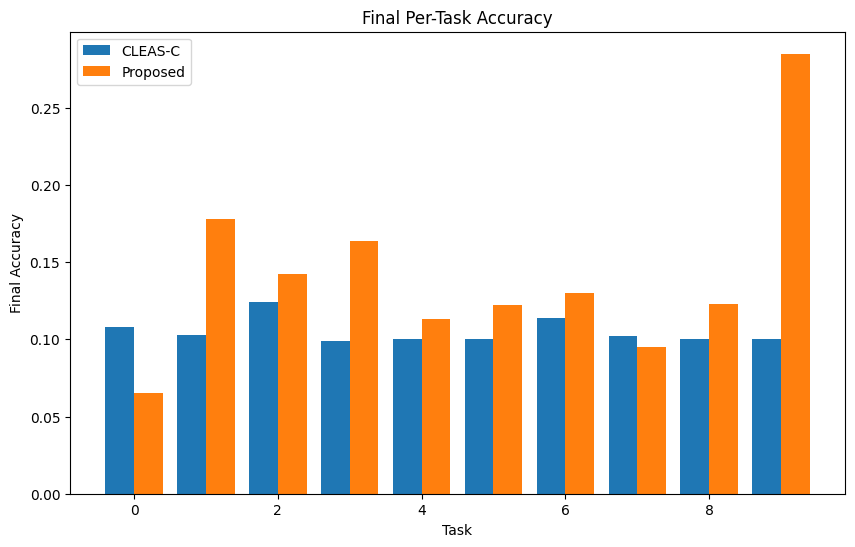

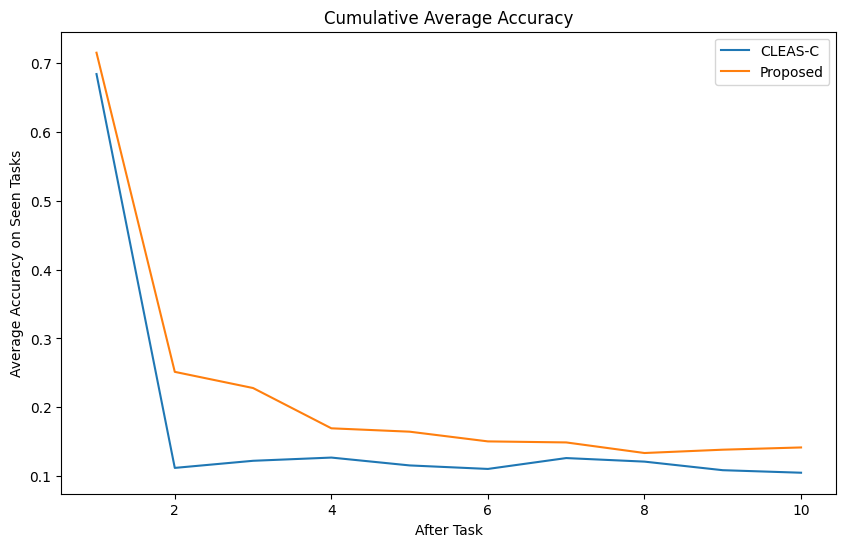

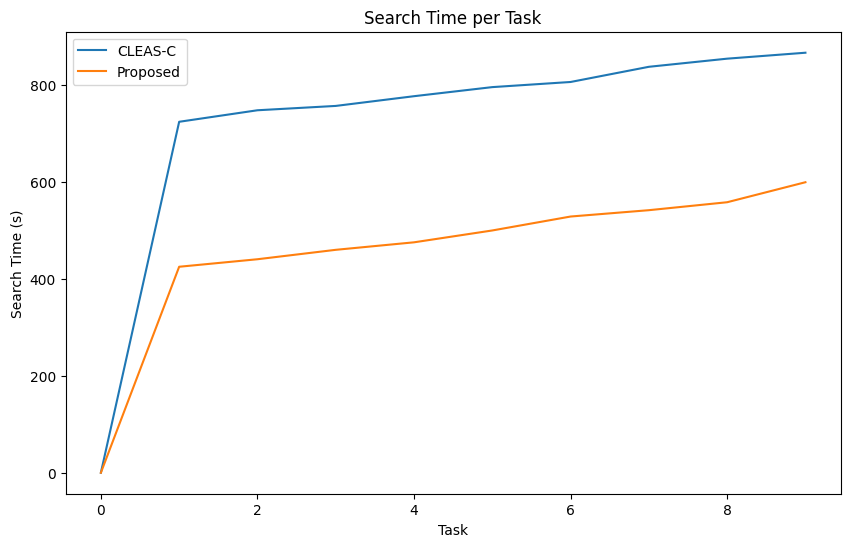

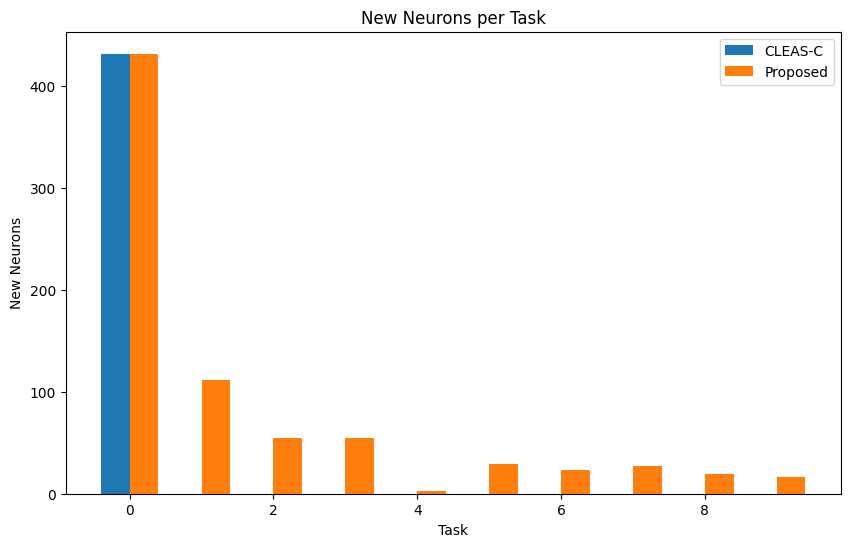

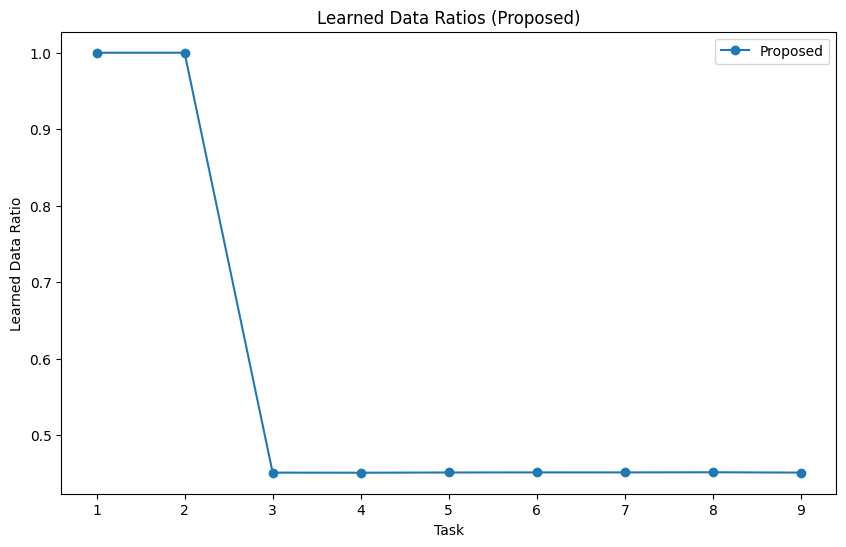

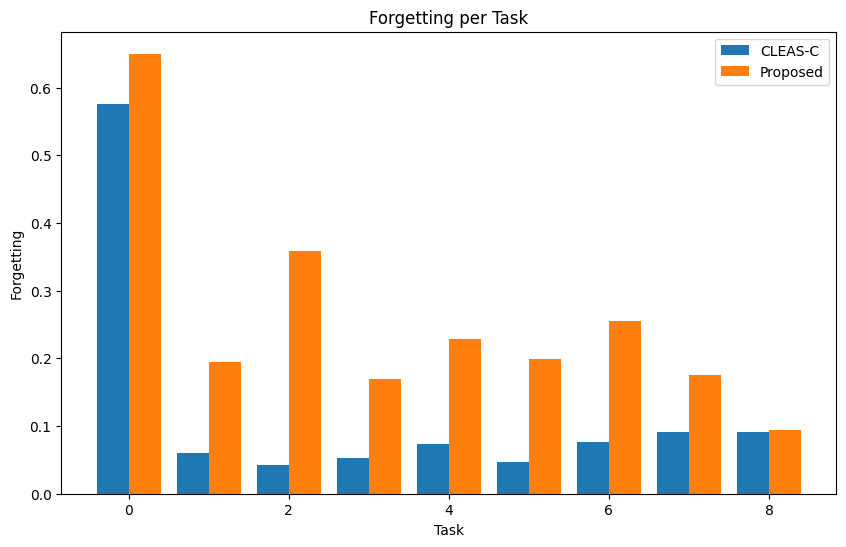


==================== DONE ====================



In [ ]:
if __name__ == "__main__":
    # Run comparison
    cleas_results, proposed_results, cleas_accs, prop_accs = run_full_comparison()
    print("\n==================== DONE ====================\n")

[CLEAS] Loading CIFAR-100 dataset...
[CLEAS] CIFAR-100 tasks successfully prepared.
[RUNNING] CLEASC on 10 tasks...
[RUNNING] PROPOSED on 10 tasks...
⏳ Still running...

Per-Task Accuracy (Right After Learning):
Task	CLEAS-C	Proposed
0	0.6840	0.7150
1	0.1630	0.3720
2	0.1670	0.5010
3	0.1520	0.3330
4	0.1740	0.3410
5	0.1470	0.3210
6	0.1900	0.3850
7	0.1930	0.2710
8	0.1910	0.2170
9	0.1000	0.2850

Final Per-Task Accuracy (After All Tasks):
Task	CLEAS-C	Proposed
0	0.1080	0.0650
1	0.1030	0.1780
2	0.1240	0.1420
3	0.0990	0.1640
4	0.1000	0.1130
5	0.1000	0.1220
6	0.1140	0.1300
7	0.1020	0.0950
8	0.1000	0.1230
9	0.1000	0.2850

Forgetting Per Task:
Task	CLEAS-C	Proposed
0	0.5760	0.6500
1	0.0600	0.1940
2	0.0430	0.3590
3	0.0530	0.1690
4	0.0740	0.2280
5	0.0470	0.1990
6	0.0760	0.2550
7	0.0910	0.1760
8	0.0910	0.0940

COMPARISON RESULTS
Metric               CLEAS-C      Proposed     Improvement 
--------------------------------------------------------------------------------
Mean After-Learn Acc:  0.2161  

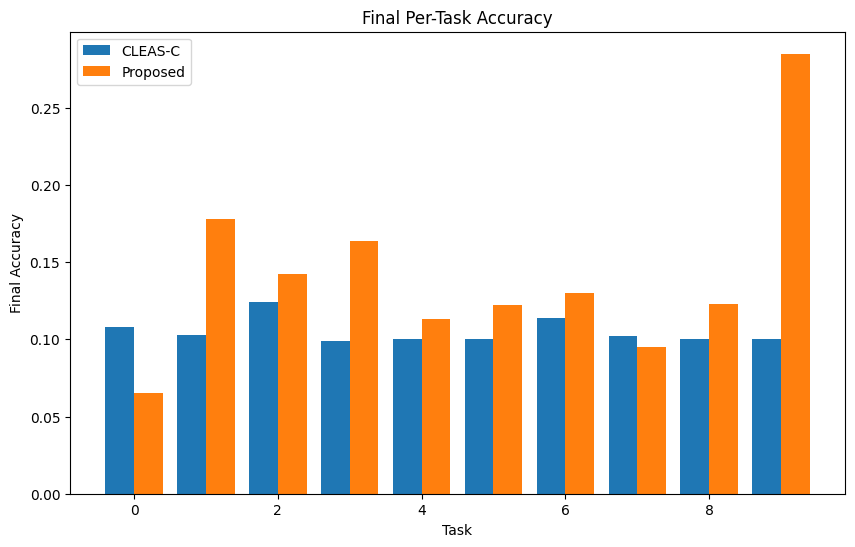

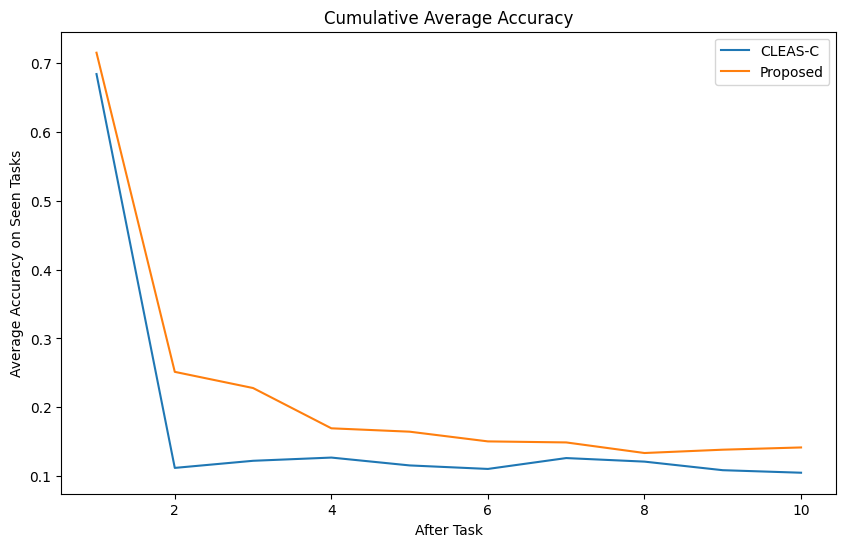

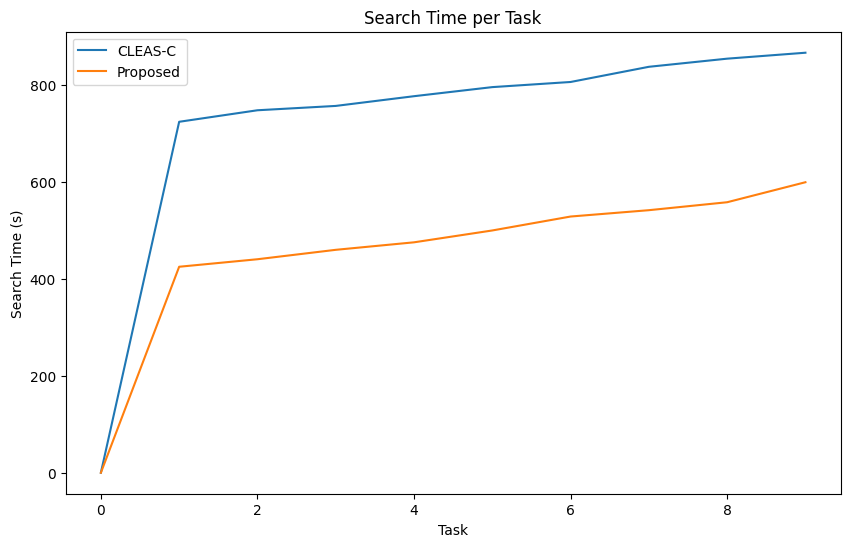

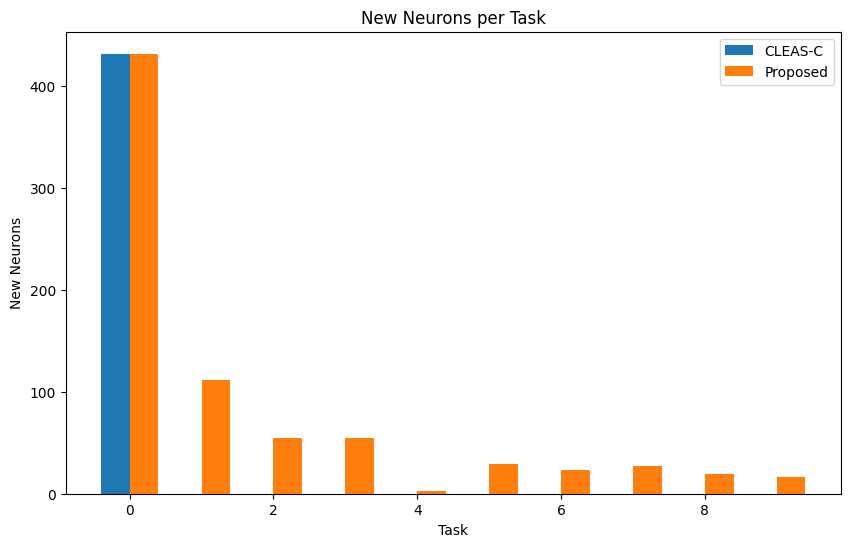

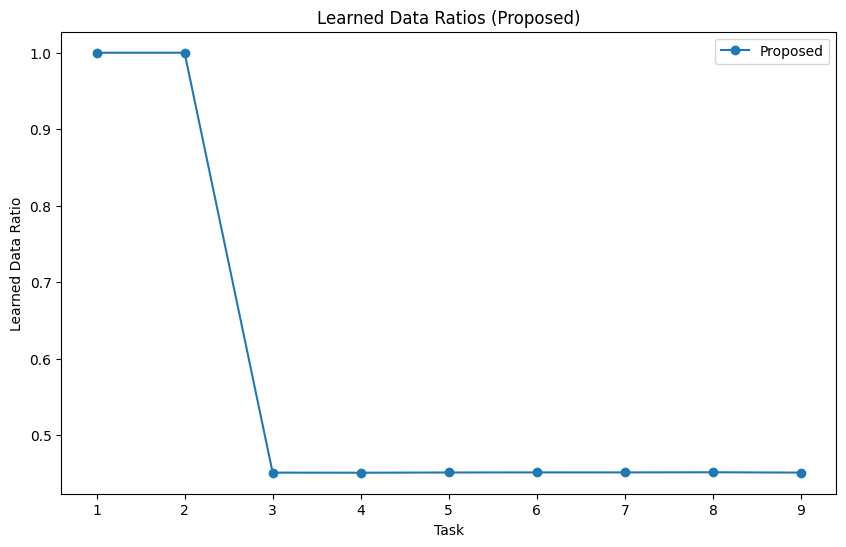

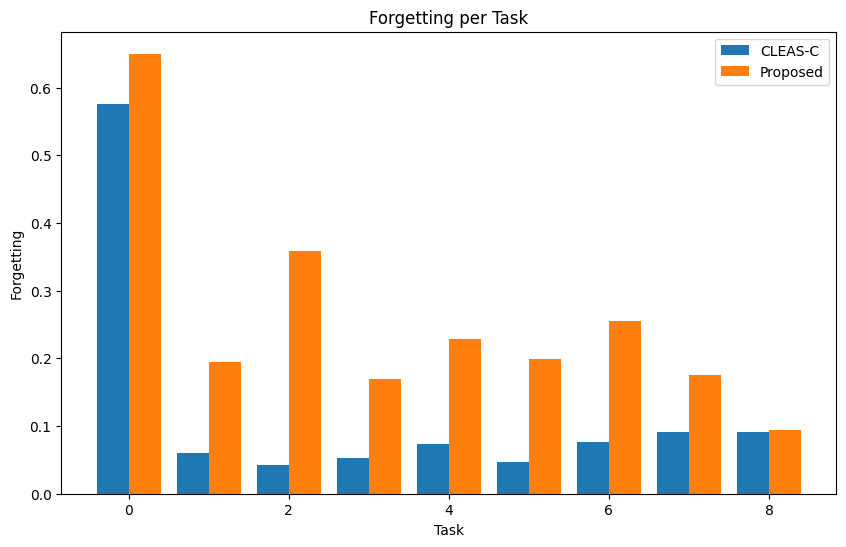


==================== DONE ====================



In [ ]:
# ============================================================
# PART 10 — COMPARATIVE EXPERIMENT RUNNER + ABLATIONS
# ============================================================
def run_full_comparison():
    train_loaders, val_loaders, test_loaders, full_train_subsets = prepare_cifar100_tasks()

    # Run both methods
    # cleas_results = run_method('cleasc', train_loaders, val_loaders, test_loaders, full_train_subsets,
    #                          'checkpoints_cleasc')
    # proposed_results = run_method('proposed', train_loaders, val_loaders, test_loaders, full_train_subsets,
    #                            'checkpoints_proposed')
    global cleas_results
    global proposed_results
    cleas_after_learn_accs = evaluate_all_tasks(cleas_results[0], cleas_results[1], cleas_results[2], test_loaders)
    prop_after_learn_accs = evaluate_all_tasks(proposed_results[0], proposed_results[1], proposed_results[2], test_loaders)

    # Compute acc_matrix
    cleas_acc_matrix = compute_acc_matrix(cleas_results[0], cleas_results[1], cleas_results[2], test_loaders)
    proposed_acc_matrix = compute_acc_matrix(proposed_results[0], proposed_results[1], proposed_results[2], test_loaders)

    cleas_final_accs = cleas_acc_matrix[-1]
    prop_final_accs = proposed_acc_matrix[-1]

    cleas_forget = compute_average_forgetting(cleas_acc_matrix)
    prop_forget = compute_average_forgetting(proposed_acc_matrix)

    cleas_new_neurons = compute_new_neurons_list(cleas_results[0])
    prop_new_neurons = compute_new_neurons_list(proposed_results[0])

    # Print per-task after-learn accs
    print("\nPer-Task Accuracy (Right After Learning):")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"]):
        print(f"{t}\t{cleas_after_learn_accs[t]:.4f}\t{prop_after_learn_accs[t]:.4f}")

    # Print final per-task accs
    print("\nFinal Per-Task Accuracy (After All Tasks):")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"]):
        print(f"{t}\t{cleas_final_accs[t]:.4f}\t{prop_final_accs[t]:.4f}")

    # Print forgetting per task
    print("\nForgetting Per Task:")
    print("Task\tCLEAS-C\tProposed")
    for t in range(CONFIG["num_tasks"] - 1):
        cleas_max = max(cleas_acc_matrix[s][t] for s in range(t, CONFIG["num_tasks"]))
        prop_max = max(proposed_acc_matrix[s][t] for s in range(t, CONFIG["num_tasks"]))
        cleas_f = cleas_max - cleas_final_accs[t]
        prop_f = prop_max - prop_final_accs[t]
        print(f"{t}\t{cleas_f:.4f}\t{prop_f:.4f}")

    # Comparison metrics
    print("\n" + "="*80)
    print("COMPARISON RESULTS")
    print("="*80)
    print(f"{'Metric':<20} {'CLEAS-C':<12} {'Proposed':<12} {'Improvement':<12}")
    print("-"*80)
    cleas_times = np.array(cleas_results[4])
    prop_times = np.array(proposed_results[4])
    print(f"Mean After-Learn Acc:{np.mean(cleas_after_learn_accs):8.4f} {np.mean(prop_after_learn_accs):8.4f} "
          f"{100*(np.mean(prop_after_learn_accs)-np.mean(cleas_after_learn_accs))/np.mean(cleas_after_learn_accs):8.1f}%")
    print(f"Mean Final Acc:     {np.mean(cleas_final_accs):8.4f} {np.mean(prop_final_accs):8.4f} "
          f"{100*(np.mean(prop_final_accs)-np.mean(cleas_final_accs))/np.mean(cleas_final_accs):8.1f}%")
    print(f"Avg Forgetting:     {cleas_forget:8.4f} {prop_forget:8.4f} "
          f"{100*(1 - prop_forget/cleas_forget if cleas_forget != 0 else 0):8.1f}% reduction")
    print(f"Mean time/task:     {cleas_times.mean():8.2f}s {prop_times.mean():8.2f}s "
          f"{100*(1-prop_times.mean()/cleas_times.mean()):8.1f}%")
    print(f"Total time:         {cleas_times.sum():8.2f}s {prop_times.sum():8.2f}s "
          f"{100*(1-prop_times.sum()/cleas_times.sum()):8.1f}%")

    # Theoretical note (as comment)
    print("\nTheoretical: Proposed saves ~ (1 - avg_ratio) * H * train_time/episode, minus ~15s overhead/task.")

    # Graphs
    tasks = list(range(CONFIG["num_tasks"]))

    # Final per-task acc
    plt.figure(figsize=(10, 6))
    plt.bar([t - 0.2 for t in tasks], cleas_final_accs, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in tasks], prop_final_accs, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Final Accuracy')
    plt.title('Final Per-Task Accuracy')
    plt.legend()
    plt.show()

    # Cumulative mean acc
    cleas_cum_mean = [np.mean(acc) for acc in cleas_acc_matrix]
    prop_cum_mean = [np.mean(acc) for acc in proposed_acc_matrix]
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, CONFIG["num_tasks"] + 1), cleas_cum_mean, label='CLEAS-C')
    plt.plot(range(1, CONFIG["num_tasks"] + 1), prop_cum_mean, label='Proposed')
    plt.xlabel('After Task')
    plt.ylabel('Average Accuracy on Seen Tasks')
    plt.title('Cumulative Average Accuracy')
    plt.legend()
    plt.show()

    # Search times per task
    plt.figure(figsize=(10, 6))
    plt.plot(tasks, cleas_results[4], label='CLEAS-C')
    plt.plot(tasks, proposed_results[4], label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Search Time (s)')
    plt.title('Search Time per Task')
    plt.legend()
    plt.show()

    # New neurons per task
    plt.figure(figsize=(10, 6))
    plt.bar([t - 0.2 for t in tasks], cleas_new_neurons, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in tasks], prop_new_neurons, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('New Neurons')
    plt.title('New Neurons per Task')
    plt.legend()
    plt.show()

    # Learned ratios (Proposed only, skip task 0)
    if proposed_results[3][0] is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, CONFIG["num_tasks"]), proposed_results[3][1:], marker='o', label='Proposed')
        plt.xlabel('Task')
        plt.ylabel('Learned Data Ratio')
        plt.title('Learned Data Ratios (Proposed)')
        plt.legend()
        plt.show()

    # Forgetting per task
    cleas_forget_per = []
    prop_forget_per = []
    for i in range(CONFIG["num_tasks"] - 1):
        cleas_max = max(cleas_acc_matrix[s][i] for s in range(i, CONFIG["num_tasks"]))
        prop_max = max(proposed_acc_matrix[s][i] for s in range(i, CONFIG["num_tasks"]))
        cleas_forget_per.append(cleas_max - cleas_final_accs[i])
        prop_forget_per.append(prop_max - prop_final_accs[i])
    plt.figure(figsize=(10, 6))
    forget_tasks = list(range(CONFIG["num_tasks"] - 1))
    plt.bar([t - 0.2 for t in forget_tasks], cleas_forget_per, width=0.4, label='CLEAS-C')
    plt.bar([t + 0.2 for t in forget_tasks], prop_forget_per, width=0.4, label='Proposed')
    plt.xlabel('Task')
    plt.ylabel('Forgetting')
    plt.title('Forgetting per Task')
    plt.legend()
    plt.show()

    return cleas_results, proposed_results, cleas_after_learn_accs, prop_after_learn_accs

if __name__ == "__main__":
    # Run comparison
    cleas_results, proposed_results, cleas_accs, prop_accs = run_full_comparison()
    print("\n==================== DONE ====================\n")